# Machine Learning Models For Motion Intention Using EMG Signals

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
import math
from utils import *
from mlModels import *

from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.feature_selection as fs
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

import keras
import tensorflow as tf
from keras.models import load_model

In [2]:
keras.backend.clear_session()
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


## Load Data

In [3]:
w_length = 200
w_increment = 100

path = 'D:\Documentos\Datasets\Grabaciones 2 Corr'

raw_data, labels, angle, speed, torque = loadAndLabel(path, w_length, w_increment)

10_ext_0_31_62.txt
10_flex_0_31_62.txt
10_flex_1333_31_62.txt
10_flex_3638_31_62.txt
10_pron_0_4_62.txt
10_pron_919_4_62.txt
10_stat_0_31_62.txt
10_sup_0_4_62.txt
10_sup_919_4_62.txt
11_ext_0_29_48.txt
11_flex_0_29_48.txt
11_flex_1333_29_48.txt
11_flex_3638_29_48.txt
11_pron_0_3_48.txt
11_pron_919_3_48.txt
11_stat_0_29_48.txt
11_sup_0_3_48.txt
11_sup_919_3_48.txt
12_ext_0_31_66.txt
12_flex_0_31_66.txt
12_flex_1333_31_66.txt
12_flex_3638_31_66.txt
12_pron_0_5_66.txt
12_pron_919_5_66.txt
12_sup_0_5_66.txt
12_sup_919_5_66.txt
13_ext_0_31_70.txt
13_flex_0_31_70.txt
13_flex_1333_31_70.txt
13_flex_3638_31_70.txt
13_pron_0_5_70.txt
13_pron_919_5_70.txt
13_stat_0_5_70.txt
13_sup_0_5_70.txt
13_sup_919_5_70.txt
14_ext_0_29_4.txt
14_flex_0_29_4.txt
14_flex_1333_29_4.txt
14_flex_3638_29_4.txt
14_pron_0_4_48.txt
14_pron_919_4_48.txt
14_stat_0_4_48.txt
14_sup_919_4_48.txt
15_ext_0_29_54.txt
15_flex_0_29_54.txt
15_flex_1333_29_54.txt
15_flex_3638_29_54.txt
15_pron_0_4_54.txt
15_pron_919_4_54.txt
15_s

In [4]:
w, ch = raw_data[0].shape
print('Number of examples (m) = ', len(raw_data))
print('Window lenght (w) = ', w)
print('Number of EMG channels (ch) = ', ch)

Number of examples (m) =  22600
Window lenght (w) =  200
Number of EMG channels (ch) =  4


In [5]:
emg_raw_arr = np.array(raw_data)[:,:,0:4]
labels_arr = np.array(labels)
angle_arr = np.array(angle)
speed_arr = np.array(speed)
torque_arr = np.array(torque)
print(emg_raw_arr.shape)

(22600, 200, 4)


## EMG Features

In [6]:
f_emg_data = EMGfeatures(emg_raw_arr)

sc = MinMaxScaler()
trans = sc.fit_transform(f_emg_data)

print(f_emg_data.shape)

c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


(22600, 44)


## Moving Average Filter

In [7]:
maf_emg_data = maf(emg_raw_arr)

ascol = maf_emg_data.reshape(-1, ch)
sc = MinMaxScaler()
trans = sc.fit_transform(ascol)

maf_emg_data = trans.reshape(-1, w, ch)
print(maf_emg_data.shape)

maf_emg_data_flat = maf_emg_data.reshape(maf_emg_data.shape[0], w*ch)
print(maf_emg_data_flat.shape)

(22600, 200, 4)
(22600, 800)


## Autoencoder Feature Extraction

In [8]:
cnn_encoder = load_model('encoder_model.h5')
cnn_encoder.summary()

Model: "Convolutional_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 200, 4, 16)        272       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 2, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 100, 2, 8)         520       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 1, 8)         0         
 2D)                                                             
                                                                 
Total params: 792
Trainable params: 792
Non-trainable params: 0
_________________________________________________________________


In [9]:
cnn_encoder.compile(optimizer='adam', loss='binary_crossentropy')
ae_emg = cnn_encoder.predict(emg_raw_arr)
print(ae_emg.shape)

ae_emg_data = ae_emg.reshape(ae_emg.shape[0], ae_emg.shape[1], ae_emg.shape[3])
print(ae_emg_data.shape)

ae_emg_data_flat = ae_emg.reshape(ae_emg.shape[0], -1)
print(ae_emg_data_flat.shape)

707/707 [==============================] - 4s 1ms/step
(22600, 50, 1, 8)
(22600, 50, 8)
(22600, 400)


In [10]:
_, _, Y_train_labels, Y_test_labels = train_test_split(f_emg_data, labels_arr, stratify=labels, test_size=0.1, random_state=1)

X_train_feat, X_test_feat, Y_train_feat, Y_test_feat = train_test_split(f_emg_data, torque_arr, stratify=labels, test_size=0.1, random_state=1)

X_train_maf, X_test_maf, Y_train_maf, Y_test_maf = train_test_split(maf_emg_data, torque_arr, stratify=labels, test_size=0.1, random_state=1)
X_train_maf_flat, X_test_maf_flat, Y_train_maf_flat, Y_test_maf_flat = train_test_split(maf_emg_data_flat, torque_arr, stratify=labels, test_size=0.1, random_state=1)

X_train_ae, X_test_ae, Y_train_ae, Y_test_ae = train_test_split(ae_emg_data, torque_arr, stratify=labels, test_size=0.1, random_state=1)
X_train_ae_flat, X_test_ae_flat, Y_train_ae_flat, Y_test_ae_flat = train_test_split(ae_emg_data_flat, torque_arr, stratify=labels, test_size=0.1, random_state=1)

# Torque Regression Training

## EMG Features

In [11]:
models_reg, models_names_reg = sklearnModelsReg()
train_scores, val_scores = cvRegression(X_train_feat, Y_train_feat, Y_train_labels, models_reg, k=5)

c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\alejo\AppData\Local\Programs\Pyt

In [12]:
mlp_train_scores, mlp_val_scores = cvKerasReg(X_train_feat, Y_train_feat, Y_train_labels, mlpReg(), k = 5)
models_names_reg.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
train_scores[2].append(mlp_train_scores[2])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])
val_scores[2].append(mlp_val_scores[2])

Epoch 1/200
64/64 [==============================] - 1s 3ms/step - loss: 7.8551 - mean_absolute_error: 1.8721 - mean_squared_error: 7.8551
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 6.0310 - mean_absolute_error: 1.5821 - mean_squared_error: 6.0310
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 5.8699 - mean_absolute_error: 1.5972 - mean_squared_error: 5.8699
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 5.5932 - mean_absolute_error: 1.5513 - mean_squared_error: 5.5932
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 5.4748 - mean_absolute_error: 1.5294 - mean_squared_error: 5.4748
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 5.4099 - mean_absolute_error: 1.5271 - mean_squared_error: 5.4099
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 5.3558 - mean_absolute_error: 1.5201 - mean_squared_error: 5.3558
Epoch 8/200
64/64 [========

In [17]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['MAE', 'MSE', 'R2']],names=['','Model'])
models_comparison_reg = pd.DataFrame(zip(train_scores[0], train_scores[1], train_scores[2], val_scores[0], val_scores[1], val_scores[2]), index=models_names_reg, columns=cols)
models_comparison_reg = models_comparison_reg.sort_values([('Val', 'MAE')], ascending=True)
models_comparison_reg


Train                              Val              \
Model                   MAE         MSE         R2       MAE         MSE   
Random Forest      0.418402    0.542517   0.951017  1.124615    3.855521   
Bagging            0.465810    0.779091   0.929658  1.182089    4.298999   
Deep MLP           0.998403    2.525061   0.771943  1.205121    3.800808   
MLP                1.318033    4.257556   0.615579  1.357390    4.522329   
SVM                1.379335    6.487756   0.414229  1.382845    6.501628   
Ridge              1.510005    5.493144   0.504039  1.513229    5.517207   
Linear Regression  1.524575    5.443913   0.508485  1.529407    5.480456   
Elastic-Net        1.660364    6.385527   0.423466  1.661336    6.393440   
Lasso              1.693060    6.490859   0.413955  1.694039    6.498096   
LARS               6.608761  250.982672 -21.759046  6.658927  246.225971   

                              
Model                     R2  
Random Forest       0.651852  
Bagging             0.611760  
Deep MLP            0.657241  
MLP                 0.591671  
SVM                 0.412823  
Ridge               0.501717  
Linear Regression   0.505076  
Elastic-Net         0.422579  
Lasso               0.413130  
LARS              -20.858319

## Moving Average Filter

In [20]:
# train_scores = [[],[],[]]
# val_scores = [[],[],[]]
# models_names_reg = []
lr = LinearRegression()
rr = Ridge()
lsr = Lasso()
en = ElasticNet()
lars = Lars()
models_reg = [lr, rr, lsr, en, lars]
models_names_reg = ['Linear Regression', 'Ridge', 'Lasso', 'Elastic-Net', 'LARS']
train_scores, val_scores = cvRegression(X_train_maf_flat, Y_train_maf, Y_train_labels, models_reg, k=5)

c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing s

In [21]:
mlp_train_scores, mlp_val_scores = cvKerasReg(X_train_maf_flat, Y_train_maf_flat, Y_train_labels, mlpReg(), k = 5)
models_names_reg.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
train_scores[2].append(mlp_train_scores[2])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])
val_scores[2].append(mlp_val_scores[2])

Epoch 1/200
64/64 [==============================] - 1s 4ms/step - loss: 7.0852 - mean_absolute_error: 1.7113 - mean_squared_error: 7.0852
Epoch 2/200
64/64 [==============================] - 0s 4ms/step - loss: 6.1315 - mean_absolute_error: 1.5762 - mean_squared_error: 6.1315
Epoch 3/200
64/64 [==============================] - 0s 3ms/step - loss: 6.0532 - mean_absolute_error: 1.5655 - mean_squared_error: 6.0532
Epoch 4/200
64/64 [==============================] - 0s 3ms/step - loss: 5.8928 - mean_absolute_error: 1.5186 - mean_squared_error: 5.8928
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 5.7144 - mean_absolute_error: 1.4923 - mean_squared_error: 5.7144
Epoch 6/200
64/64 [==============================] - 0s 3ms/step - loss: 5.5779 - mean_absolute_error: 1.4713 - mean_squared_error: 5.5779
Epoch 7/200
64/64 [==============================] - 0s 3ms/step - loss: 5.4220 - mean_absolute_error: 1.4332 - mean_squared_error: 5.4220
Epoch 8/200
64/64 [========

In [22]:
cnn_train_scores, cnn_val_scores = cvKerasReg(X_train_maf.reshape(X_train_maf.shape[0],w,ch,1), Y_train_maf, Y_train_labels, cnnReg(), k = 5)
models_names_reg.append('CNN')
train_scores[0].append(cnn_train_scores[0])
train_scores[1].append(cnn_train_scores[1])
train_scores[2].append(cnn_train_scores[2])
val_scores[0].append(cnn_val_scores[0])
val_scores[1].append(cnn_val_scores[1])
val_scores[2].append(cnn_val_scores[2])

Epoch 1/200
64/64 [==============================] - 2s 6ms/step - loss: 10.3848 - mean_absolute_error: 2.0849 - mean_squared_error: 10.3848
Epoch 2/200
64/64 [==============================] - 0s 5ms/step - loss: 6.3659 - mean_absolute_error: 1.6426 - mean_squared_error: 6.3659
Epoch 3/200
64/64 [==============================] - 0s 5ms/step - loss: 6.0600 - mean_absolute_error: 1.5552 - mean_squared_error: 6.0600
Epoch 4/200
64/64 [==============================] - 0s 5ms/step - loss: 5.9425 - mean_absolute_error: 1.5131 - mean_squared_error: 5.9425
Epoch 5/200
64/64 [==============================] - 0s 5ms/step - loss: 5.7991 - mean_absolute_error: 1.4856 - mean_squared_error: 5.7991
Epoch 6/200
64/64 [==============================] - 0s 5ms/step - loss: 5.6957 - mean_absolute_error: 1.4762 - mean_squared_error: 5.6957
Epoch 7/200
64/64 [==============================] - 0s 5ms/step - loss: 5.5587 - mean_absolute_error: 1.4533 - mean_squared_error: 5.5587
Epoch 8/200
64/64 [======

In [23]:
lstm_train_scores, lstm_val_scores = cvKerasReg(X_train_maf, Y_train_maf, Y_train_labels, lstm_rnnReg(), k = 5)
models_names_reg.append('LSTM')
train_scores[0].append(lstm_train_scores[0])
train_scores[1].append(lstm_train_scores[1])
train_scores[2].append(lstm_train_scores[2])
val_scores[0].append(lstm_val_scores[0])
val_scores[1].append(lstm_val_scores[1])
val_scores[2].append(lstm_val_scores[2])

Epoch 1/200
64/64 [==============================] - 3s 15ms/step - loss: 12.5333 - mean_absolute_error: 2.1152 - mean_squared_error: 12.5333
Epoch 2/200
64/64 [==============================] - 1s 14ms/step - loss: 8.7832 - mean_absolute_error: 1.9617 - mean_squared_error: 8.7832
Epoch 3/200
64/64 [==============================] - 1s 14ms/step - loss: 7.2065 - mean_absolute_error: 1.6543 - mean_squared_error: 7.2065
Epoch 4/200
64/64 [==============================] - 1s 15ms/step - loss: 7.4138 - mean_absolute_error: 1.7825 - mean_squared_error: 7.4138
Epoch 5/200
64/64 [==============================] - 1s 14ms/step - loss: 7.3611 - mean_absolute_error: 1.7124 - mean_squared_error: 7.3611
Epoch 6/200
64/64 [==============================] - 1s 13ms/step - loss: 6.3920 - mean_absolute_error: 1.5953 - mean_squared_error: 6.3920
Epoch 7/200
64/64 [==============================] - 1s 13ms/step - loss: 7.4276 - mean_absolute_error: 1.7048 - mean_squared_error: 7.4276
Epoch 8/200
64/64 

In [24]:
gru_train_scores, gru_val_scores = cvKerasReg(X_train_maf, Y_train_maf, Y_train_labels, gru_rnnReg(), k = 5)
models_names_reg.append('GRU')
train_scores[0].append(gru_train_scores[0])
train_scores[1].append(gru_train_scores[1])
train_scores[2].append(gru_train_scores[2])
val_scores[0].append(gru_val_scores[0])
val_scores[1].append(gru_val_scores[1])
val_scores[2].append(gru_val_scores[2])

Epoch 1/200
64/64 [==============================] - 3s 17ms/step - loss: 12.4450 - mean_absolute_error: 2.0759 - mean_squared_error: 12.4450
Epoch 2/200
64/64 [==============================] - 1s 16ms/step - loss: 8.8248 - mean_absolute_error: 2.0461 - mean_squared_error: 8.8248
Epoch 3/200
64/64 [==============================] - 1s 16ms/step - loss: 6.0912 - mean_absolute_error: 1.5175 - mean_squared_error: 6.0912
Epoch 4/200
64/64 [==============================] - 1s 15ms/step - loss: 5.7529 - mean_absolute_error: 1.4838 - mean_squared_error: 5.7529
Epoch 5/200
64/64 [==============================] - 1s 16ms/step - loss: 5.6242 - mean_absolute_error: 1.4604 - mean_squared_error: 5.6242
Epoch 6/200
64/64 [==============================] - 1s 15ms/step - loss: 5.5408 - mean_absolute_error: 1.4574 - mean_squared_error: 5.5408
Epoch 7/200
64/64 [==============================] - 1s 15ms/step - loss: 5.4768 - mean_absolute_error: 1.4535 - mean_squared_error: 5.4768
Epoch 8/200
64/64 

In [27]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['MAE', 'MSE', 'R2']],names=['','Model'])
models_comparison_reg = pd.DataFrame(zip(train_scores[0], train_scores[1], train_scores[2], val_scores[0], val_scores[1], val_scores[2]), index=models_names_reg, columns=cols)
models_comparison_reg = models_comparison_reg.sort_values([('Val', 'MAE')], ascending=True)
models_comparison_reg

Train                                       Val  \
Model                       MAE           MSE            R2           MAE   
Deep MLP               0.592655  8.560946e-01  9.226670e-01      1.133384   
GRU                    1.214670  4.086762e+00  6.309708e-01      1.263471   
LSTM                   1.283694  4.448847e+00  5.982750e-01      1.321772   
CNN                    1.194273  3.656870e+00  6.697871e-01      1.334742   
Ridge                  1.552340  5.910288e+00  4.663726e-01      1.582093   
Linear Regression      1.510194  5.481131e+00  5.051198e-01      1.657157   
Lasso                  2.372539  1.107585e+01  0.000000e+00      2.372695   
Elastic-Net            2.372539  1.107585e+01  0.000000e+00      2.372695   
LARS               57544.193635  4.409214e+10 -3.958523e+09  62675.063088   

                                               
Model                       MSE            R2  
Deep MLP           3.611202e+00  6.749806e-01  
GRU                4.472326e+00  5.965197e-01  
LSTM               4.751841e+00  5.711603e-01  
CNN                4.680968e+00  5.775763e-01  
Ridge              6.212252e+00  4.389019e-01  
Linear Regression  6.897115e+00  3.770362e-01  
Lasso              1.107678e+01 -2.109336e-04  
Elastic-Net        1.107678e+01 -2.109336e-04  
LARS               6.500320e+10 -6.004889e+09

## Autoencoder Feature Extraction

In [ ]:
# train_scores = [[],[],[]]
# val_scores = [[],[],[]]
# models_names_reg = []
lr = LinearRegression()
rr = Ridge()
lsr = Lasso()
en = ElasticNet()
lars = Lars()
models_reg = [lr, rr, lsr, en, lars]
models_names_reg = ['Ridge', 'Lasso', 'Elastic-Net', 'LARS']
train_scores, val_scores = cvRegression(X_train_ae, Y_train_ae, Y_train_labels, models_reg, k=5)

In [ ]:
mlp_train_scores, mlp_val_scores = cvKerasReg(X_train_ae_flat, Y_train_ae_flat, Y_train_labels, mlpReg(), k = 5)
models_names_reg.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
train_scores[2].append(mlp_train_scores[2])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])
val_scores[2].append(mlp_val_scores[2])

Epoch 1/200
64/64 [==============================] - 1s 2ms/step - loss: 10.7220 - mean_absolute_error: 2.1093 - mean_squared_error: 10.7220
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 8.8603 - mean_absolute_error: 2.1411 - mean_squared_error: 8.8603
Epoch 3/200
64/64 [==============================] - 0s 3ms/step - loss: 8.2783 - mean_absolute_error: 2.0568 - mean_squared_error: 8.2783
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 7.6199 - mean_absolute_error: 1.9412 - mean_squared_error: 7.6199
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 7.1688 - mean_absolute_error: 1.8206 - mean_squared_error: 7.1688
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 6.9060 - mean_absolute_error: 1.7529 - mean_squared_error: 6.9060
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 6.8154 - mean_absolute_error: 1.7307 - mean_squared_error: 6.8154
Epoch 8/200
64/64 [======

In [ ]:
cnn_train_scores, cnn_val_scores = cvKerasReg(X_train_ae.reshape(X_train_ae.shape[0],X_train_ae.shape[1],X_train_ae.shape[2],1), Y_train_ae, Y_train_labels, cnnReg(), k = 5)
models_names_reg.append('CNN')
train_scores[0].append(cnn_train_scores[0])
train_scores[1].append(cnn_train_scores[1])
train_scores[2].append(cnn_train_scores[2])
val_scores[0].append(cnn_val_scores[0])
val_scores[1].append(cnn_val_scores[1])
val_scores[2].append(cnn_val_scores[2])

Epoch 1/200
64/64 [==============================] - 2s 5ms/step - loss: 10.4258 - mean_absolute_error: 2.1916 - mean_squared_error: 10.4258
Epoch 2/200
64/64 [==============================] - 0s 4ms/step - loss: 8.7700 - mean_absolute_error: 2.0833 - mean_squared_error: 8.7700
Epoch 3/200
64/64 [==============================] - 0s 4ms/step - loss: 7.9417 - mean_absolute_error: 1.9710 - mean_squared_error: 7.9417
Epoch 4/200
64/64 [==============================] - 0s 4ms/step - loss: 6.8242 - mean_absolute_error: 1.7593 - mean_squared_error: 6.8242
Epoch 5/200
64/64 [==============================] - 0s 4ms/step - loss: 6.5136 - mean_absolute_error: 1.6801 - mean_squared_error: 6.5136
Epoch 6/200
64/64 [==============================] - 0s 4ms/step - loss: 6.3097 - mean_absolute_error: 1.6360 - mean_squared_error: 6.3097
Epoch 7/200
64/64 [==============================] - 0s 4ms/step - loss: 6.0205 - mean_absolute_error: 1.5740 - mean_squared_error: 6.0205
Epoch 8/200
64/64 [======

In [ ]:
lstm_train_scores, lstm_val_scores = cvKerasReg(X_train_ae, Y_train_ae, Y_train_labels, lstm_rnnReg(), k = 5)
models_names_reg.append('LSTM')
train_scores[0].append(lstm_train_scores[0])
train_scores[1].append(lstm_train_scores[1])
train_scores[2].append(lstm_train_scores[2])
val_scores[0].append(lstm_val_scores[0])
val_scores[1].append(lstm_val_scores[1])
val_scores[2].append(lstm_val_scores[2])

Epoch 1/200
64/64 [==============================] - 3s 9ms/step - loss: 11.9193 - mean_absolute_error: 2.2570 - mean_squared_error: 11.9193
Epoch 2/200
64/64 [==============================] - 0s 6ms/step - loss: 8.3932 - mean_absolute_error: 1.9841 - mean_squared_error: 8.3932
Epoch 3/200
64/64 [==============================] - 0s 7ms/step - loss: 6.6016 - mean_absolute_error: 1.6985 - mean_squared_error: 6.6016
Epoch 4/200
64/64 [==============================] - 0s 6ms/step - loss: 6.2637 - mean_absolute_error: 1.6073 - mean_squared_error: 6.2637
Epoch 5/200
64/64 [==============================] - 0s 6ms/step - loss: 5.9913 - mean_absolute_error: 1.5686 - mean_squared_error: 5.9913
Epoch 6/200
64/64 [==============================] - 0s 6ms/step - loss: 6.0246 - mean_absolute_error: 1.5530 - mean_squared_error: 6.0246
Epoch 7/200
64/64 [==============================] - 0s 6ms/step - loss: 5.8800 - mean_absolute_error: 1.5535 - mean_squared_error: 5.8800
Epoch 8/200
64/64 [======

In [ ]:
gru_train_scores, gru_val_scores = cvKerasReg(X_train_ae, Y_train_ae, Y_train_labels, gru_rnnReg(), k = 5)
models_names_reg.append('GRU')
train_scores[0].append(gru_train_scores[0])
train_scores[1].append(gru_train_scores[1])
train_scores[2].append(gru_train_scores[2])
val_scores[0].append(gru_val_scores[0])
val_scores[1].append(gru_val_scores[1])
val_scores[2].append(gru_val_scores[2])

Epoch 1/200
64/64 [==============================] - 2s 7ms/step - loss: 12.6958 - mean_absolute_error: 2.2290 - mean_squared_error: 12.6958
Epoch 2/200
64/64 [==============================] - 0s 6ms/step - loss: 9.5668 - mean_absolute_error: 2.2776 - mean_squared_error: 9.5668
Epoch 3/200
64/64 [==============================] - 0s 6ms/step - loss: 7.6687 - mean_absolute_error: 1.8115 - mean_squared_error: 7.6687
Epoch 4/200
64/64 [==============================] - 0s 6ms/step - loss: 6.6949 - mean_absolute_error: 1.6671 - mean_squared_error: 6.6949
Epoch 5/200
64/64 [==============================] - 0s 6ms/step - loss: 6.3122 - mean_absolute_error: 1.6266 - mean_squared_error: 6.3122
Epoch 6/200
64/64 [==============================] - 0s 6ms/step - loss: 6.1028 - mean_absolute_error: 1.5779 - mean_squared_error: 6.1028
Epoch 7/200
64/64 [==============================] - 0s 6ms/step - loss: 6.1316 - mean_absolute_error: 1.5747 - mean_squared_error: 6.1316
Epoch 8/200
64/64 [======

In [ ]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['MAE', 'MSE', 'R2']],names=['','Model'])
models_comparison_reg = pd.DataFrame(zip(train_scores[0], train_scores[1], train_scores[2], val_scores[0], val_scores[1], val_scores[2]), index=models_names_reg, columns=cols)
models_comparison_reg = models_comparison_reg.sort_values([('Val', 'MAE')], ascending=True)
models_comparison_reg

Train                           Val                    
Model          MAE       MSE        R2       MAE       MSE        R2
GRU       1.138216  3.466646  0.707392  1.229980  4.092825  0.654684
LSTM      1.136309  3.466591  0.707393  1.236532  4.194531  0.646587
CNN       1.024532  2.710159  0.771257  1.281785  4.414329  0.627554
Deep MLP  0.911196  2.022683  0.829244  1.378926  4.949907  0.583500

# Model Test

In [64]:
X_train_feat, X_test_feat, Y_train_feat, Y_test_feat = train_test_split(f_emg_data, torque_arr, test_size=0.1, shuffle=True)
deep_mlp = mlpReg()
deep_mlp.compile(optimizer='adam', loss='mean_squared_error', metrics=['MeanAbsoluteError','MeanSquaredError','RootMeanSquaredError'])
deep_mlp.fit(x=X_train_feat, y=Y_train_feat, epochs=200, batch_size=256)

Epoch 1/200
159/159 [==============================] - 1s 4ms/step - loss: 7.3390 - mean_absolute_error: 1.7940 - mean_squared_error: 7.3390 - root_mean_squared_error: 2.7090
Epoch 2/200
159/159 [==============================] - 1s 3ms/step - loss: 5.6091 - mean_absolute_error: 1.5298 - mean_squared_error: 5.6091 - root_mean_squared_error: 2.3684
Epoch 3/200
159/159 [==============================] - 1s 3ms/step - loss: 5.4469 - mean_absolute_error: 1.5289 - mean_squared_error: 5.4469 - root_mean_squared_error: 2.3339
Epoch 4/200
159/159 [==============================] - 0s 3ms/step - loss: 5.3189 - mean_absolute_error: 1.5102 - mean_squared_error: 5.3189 - root_mean_squared_error: 2.3063
Epoch 5/200
159/159 [==============================] - 0s 3ms/step - loss: 5.1992 - mean_absolute_error: 1.4864 - mean_squared_error: 5.1992 - root_mean_squared_error: 2.2802
Epoch 6/200
159/159 [==============================] - 0s 3ms/step - loss: 5.2058 - mean_absolute_error: 1.4931 - mean_square

In [67]:
deep_mlp.evaluate(X_train_feat,Y_train_feat)
deep_mlp.evaluate(X_test_feat,Y_test_feat)

142/142 [==============================] - 0s 2ms/step - loss: 3.7256 - mean_absolute_error: 1.1510 - mean_squared_error: 3.7256 - root_mean_squared_error: 1.9302


[3.7255589962005615, 1.15099036693573, 3.7255589962005615, 1.9301706552505493]

142/142 [==============================] - 0s 936us/step


Text(0.5, 0, 'Ventana')

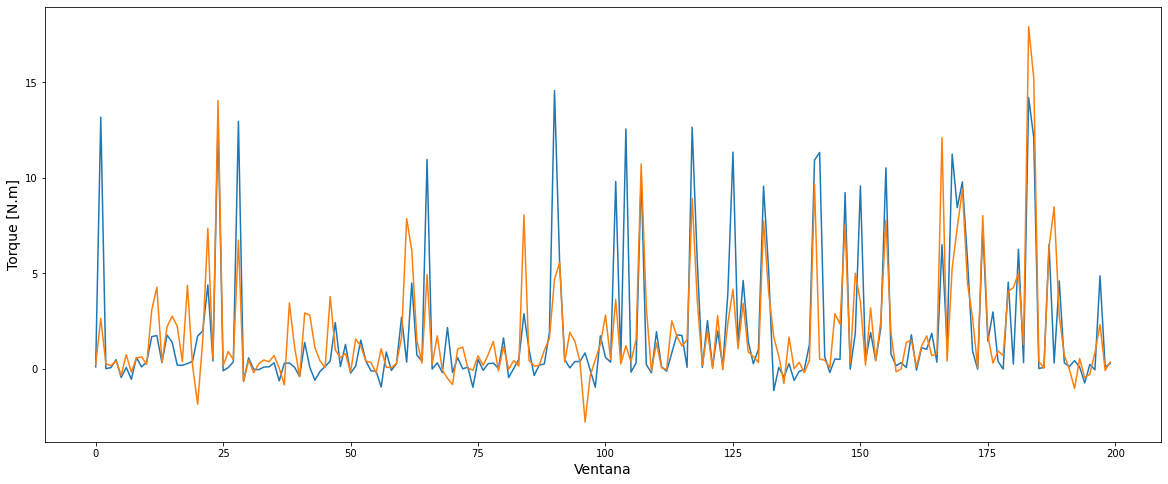

In [68]:
predicted = deep_mlp.predict(X_test_feat)
n = 200
plt.figure(figsize=(20,8))
plt.plot(Y_test_feat[0:n])
plt.plot(predicted[0:n])
plt.ylabel("Torque [N.m]", fontsize=14)
plt.xlabel("Ventana", fontsize=14)

# Speed Regression Training

In [69]:
X_train_feat, X_test_feat, Y_train_feat, Y_test_feat = train_test_split(f_emg_data, speed_arr, stratify=labels, test_size=0.1, random_state=1)

X_train_maf, X_test_maf, Y_train_maf, Y_test_maf = train_test_split(maf_emg_data, speed_arr, stratify=labels, test_size=0.1, random_state=1)
X_train_maf_flat, X_test_maf_flat, Y_train_maf_flat, Y_test_maf_flat = train_test_split(maf_emg_data_flat, speed_arr, stratify=labels, test_size=0.1, random_state=1)

X_train_ae, X_test_ae, Y_train_ae, Y_test_ae = train_test_split(ae_emg_data, speed_arr, stratify=labels, test_size=0.1, random_state=1)
X_train_ae_flat, X_test_ae_flat, Y_train_ae_flat, Y_test_ae_flat = train_test_split(ae_emg_data_flat, speed_arr, stratify=labels, test_size=0.1, random_state=1)

## EMG Features

In [39]:
models_reg, models_names_reg = sklearnModelsReg()
train_scores, val_scores = cvRegression(X_train_feat, Y_train_feat, Y_train_labels, models_reg, k=5)

c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

In [70]:
mlp_train_scores, mlp_val_scores = cvKerasReg(X_train_feat, Y_train_feat, Y_train_labels, mlpReg(), k = 5)
models_names_reg.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
train_scores[2].append(mlp_train_scores[2])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])
val_scores[2].append(mlp_val_scores[2])

Epoch 1/500
127/127 [==============================] - 1s 3ms/step - loss: 9733.6885 - mean_absolute_error: 71.6847 - mean_squared_error: 9733.6885
Epoch 2/500
127/127 [==============================] - 0s 3ms/step - loss: 9562.0654 - mean_absolute_error: 71.2208 - mean_squared_error: 9562.0654
Epoch 3/500
127/127 [==============================] - 0s 2ms/step - loss: 9506.7705 - mean_absolute_error: 70.8809 - mean_squared_error: 9506.7705
Epoch 4/500
127/127 [==============================] - 0s 2ms/step - loss: 9476.7734 - mean_absolute_error: 70.7538 - mean_squared_error: 9476.7734
Epoch 5/500
127/127 [==============================] - 0s 2ms/step - loss: 9442.7041 - mean_absolute_error: 70.5382 - mean_squared_error: 9442.7041
Epoch 6/500
127/127 [==============================] - 0s 2ms/step - loss: 9427.3281 - mean_absolute_error: 70.5009 - mean_squared_error: 9427.3281
Epoch 7/500
127/127 [==============================] - 0s 2ms/step - loss: 9379.4004 - mean_absolute_error: 70.2

KeyboardInterrupt: 

In [41]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['MAE', 'MSE', 'R2']],names=['','Model'])
models_comparison_reg = pd.DataFrame(zip(train_scores[0], train_scores[1], train_scores[2], val_scores[0], val_scores[1], val_scores[2]), index=models_names_reg, columns=cols)
models_comparison_reg = models_comparison_reg.sort_values([('Val', 'MAE')], ascending=True)
models_comparison_reg


Train                                 Val  \
Model                       MAE           MSE        R2         MAE   
Random Forest      4.338806e+01  3.861509e+03  0.917684  116.589585   
Bagging            4.909369e+01  5.570020e+03  0.881264  123.212217   
Gradient Boosting  1.336217e+02  3.172032e+04  0.323816  137.600933   
Deep MLP           1.367194e+02  3.317635e+04  0.292724  138.396985   
MLP                1.431723e+02  3.597224e+04  0.233177  144.039275   
Stacking           9.693953e+01  1.577124e+04  0.663802  144.368239   
Linear Regression  1.497409e+02  3.853822e+04  0.178479  149.991757   
Decision Tree      8.775401e-15  2.079716e-27  1.000000  151.779064   
AdaBoost           1.516680e+02  3.798319e+04  0.190311  152.653855   
KNN                1.268979e+02  2.860454e+04  0.390235  156.116883   
SVM                1.583904e+02  4.338151e+04  0.075234  158.445490   

                                           
Model                       MSE        R2  
Random Forest      27479.825593  0.414135  
Bagging            30396.025400  0.351957  
Gradient Boosting  33603.343569  0.283583  
Deep MLP           33974.425781  0.275780  
MLP                36367.419116  0.224664  
Stacking           36697.741014  0.217623  
Linear Regression  38692.515674  0.175091  
Decision Tree      58523.380947 -0.247687  
AdaBoost           38675.504286  0.175444  
KNN                43101.868775  0.081096  
SVM                43397.063018  0.074786

## Moving Average Filter

In [42]:
train_scores = [[],[],[]]
val_scores = [[],[],[]]
models_names_reg = []

In [43]:
mlp_train_scores, mlp_val_scores = cvKerasReg(X_train_maf_flat, Y_train_maf_flat, Y_train_labels, mlpReg(), k = 5)
models_names_reg.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
train_scores[2].append(mlp_train_scores[2])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])
val_scores[2].append(mlp_val_scores[2])

Epoch 1/200
64/64 [==============================] - 0s 3ms/step - loss: 66245.7344 - mean_absolute_error: 195.7620 - mean_squared_error: 66245.7344
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 60280.8477 - mean_absolute_error: 184.5022 - mean_squared_error: 60280.8477
Epoch 3/200
64/64 [==============================] - 0s 3ms/step - loss: 51370.7461 - mean_absolute_error: 169.2339 - mean_squared_error: 51370.7461
Epoch 4/200
64/64 [==============================] - 0s 3ms/step - loss: 47158.1055 - mean_absolute_error: 164.7747 - mean_squared_error: 47158.1055
Epoch 5/200
64/64 [==============================] - 0s 3ms/step - loss: 46609.1328 - mean_absolute_error: 164.4234 - mean_squared_error: 46609.1328
Epoch 6/200
64/64 [==============================] - 0s 3ms/step - loss: 46414.4336 - mean_absolute_error: 164.1542 - mean_squared_error: 46414.4336
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 46243.8398 - mean_absolute_error:

In [44]:
cnn_train_scores, cnn_val_scores = cvKerasReg(X_train_maf.reshape(X_train_maf.shape[0],w,ch,1), Y_train_maf, Y_train_labels, cnnReg(), k = 5)
models_names_reg.append('CNN')
train_scores[0].append(cnn_train_scores[0])
train_scores[1].append(cnn_train_scores[1])
train_scores[2].append(cnn_train_scores[2])
val_scores[0].append(cnn_val_scores[0])
val_scores[1].append(cnn_val_scores[1])
val_scores[2].append(cnn_val_scores[2])

Epoch 1/200
64/64 [==============================] - 1s 6ms/step - loss: 66569.9062 - mean_absolute_error: 196.4548 - mean_squared_error: 66569.9062
Epoch 2/200
64/64 [==============================] - 0s 5ms/step - loss: 49087.3359 - mean_absolute_error: 172.4558 - mean_squared_error: 49087.3359
Epoch 3/200
64/64 [==============================] - 0s 5ms/step - loss: 44376.0039 - mean_absolute_error: 168.7821 - mean_squared_error: 44376.0039
Epoch 4/200
64/64 [==============================] - 0s 5ms/step - loss: 44261.2461 - mean_absolute_error: 168.3526 - mean_squared_error: 44261.2461
Epoch 5/200
64/64 [==============================] - 0s 5ms/step - loss: 44183.8438 - mean_absolute_error: 168.1549 - mean_squared_error: 44183.8438
Epoch 6/200
64/64 [==============================] - 0s 5ms/step - loss: 44130.7266 - mean_absolute_error: 167.8137 - mean_squared_error: 44130.7266
Epoch 7/200
64/64 [==============================] - 0s 5ms/step - loss: 44098.5117 - mean_absolute_error:

In [45]:
lstm_train_scores, lstm_val_scores = cvKerasReg(X_train_maf, Y_train_maf, Y_train_labels, lstm_rnnReg(), k = 5)
models_names_reg.append('LSTM')
train_scores[0].append(lstm_train_scores[0])
train_scores[1].append(lstm_train_scores[1])
train_scores[2].append(lstm_train_scores[2])
val_scores[0].append(lstm_val_scores[0])
val_scores[1].append(lstm_val_scores[1])
val_scores[2].append(lstm_val_scores[2])

Epoch 1/200
64/64 [==============================] - 2s 15ms/step - loss: 67178.9375 - mean_absolute_error: 197.5163 - mean_squared_error: 67178.9375
Epoch 2/200
64/64 [==============================] - 1s 13ms/step - loss: 64088.2383 - mean_absolute_error: 192.1107 - mean_squared_error: 64088.2383
Epoch 3/200
64/64 [==============================] - 1s 14ms/step - loss: 59428.6328 - mean_absolute_error: 184.3242 - mean_squared_error: 59428.6328
Epoch 4/200
64/64 [==============================] - 1s 14ms/step - loss: 54920.6484 - mean_absolute_error: 177.3521 - mean_squared_error: 54920.6484
Epoch 5/200
64/64 [==============================] - 1s 13ms/step - loss: 51230.4414 - mean_absolute_error: 173.2895 - mean_squared_error: 51230.4414
Epoch 6/200
64/64 [==============================] - 1s 13ms/step - loss: 48778.1602 - mean_absolute_error: 172.2105 - mean_squared_error: 48778.1602
Epoch 7/200
64/64 [==============================] - 1s 14ms/step - loss: 47473.3320 - mean_absolute

In [46]:
gru_train_scores, gru_val_scores = cvKerasReg(X_train_maf, Y_train_maf, Y_train_labels, gru_rnnReg(), k = 5)
models_names_reg.append('GRU')
train_scores[0].append(gru_train_scores[0])
train_scores[1].append(gru_train_scores[1])
train_scores[2].append(gru_train_scores[2])
val_scores[0].append(gru_val_scores[0])
val_scores[1].append(gru_val_scores[1])
val_scores[2].append(gru_val_scores[2])

Epoch 1/200
64/64 [==============================] - 3s 20ms/step - loss: 66882.8906 - mean_absolute_error: 196.9831 - mean_squared_error: 66882.8906
Epoch 2/200
64/64 [==============================] - 1s 18ms/step - loss: 62527.5508 - mean_absolute_error: 189.3563 - mean_squared_error: 62527.5508
Epoch 3/200
64/64 [==============================] - 1s 18ms/step - loss: 58384.1211 - mean_absolute_error: 182.6689 - mean_squared_error: 58384.1211
Epoch 4/200
64/64 [==============================] - 1s 18ms/step - loss: 54582.0273 - mean_absolute_error: 176.8584 - mean_squared_error: 54582.0273
Epoch 5/200
64/64 [==============================] - 1s 18ms/step - loss: 51396.2148 - mean_absolute_error: 173.4117 - mean_squared_error: 51396.2148
Epoch 6/200
64/64 [==============================] - 1s 17ms/step - loss: 49116.0039 - mean_absolute_error: 172.2003 - mean_squared_error: 49116.0039
Epoch 7/200
64/64 [==============================] - 1s 18ms/step - loss: 47744.3633 - mean_absolute

In [47]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['MAE', 'MSE', 'R2']],names=['','Model'])
models_comparison_reg = pd.DataFrame(zip(train_scores[0], train_scores[1], train_scores[2], val_scores[0], val_scores[1], val_scores[2]), index=models_names_reg, columns=cols)
models_comparison_reg = models_comparison_reg.sort_values([('Val', 'MAE')], ascending=True)
models_comparison_reg

Train                                 Val                \
Model            MAE           MSE        R2         MAE           MSE   
CNN       143.745786  35878.007812  0.235124  146.062903  37119.643750   
LSTM      144.489661  36472.227344  0.222440  146.185043  37338.397656   
Deep MLP  142.789957  35901.654687  0.234625  146.684189  37693.828125   
GRU       145.589301  36631.729688  0.219074  146.896927  37368.212500   

                    
Model           R2  
CNN       0.208719  
LSTM      0.204181  
Deep MLP  0.196489  
GRU       0.203457

## Autoencoder Feature Extraction

In [48]:
train_scores = [[],[],[]]
val_scores = [[],[],[]]
models_names_reg = []

In [ ]:
mlp_train_scores, mlp_val_scores = cvKerasReg(X_train_ae_flat, Y_train_ae_flat, Y_train_labels, mlpReg(), k = 5)
models_names_reg.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
train_scores[2].append(mlp_train_scores[2])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])
val_scores[2].append(mlp_val_scores[2])

In [ ]:
cnn_train_scores, cnn_val_scores = cvKerasReg(X_train_ae.reshape(X_train_ae.shape[0],X_train_ae.shape[1],X_train_ae.shape[2],1), Y_train_ae, Y_train_labels, cnnReg(), k = 5)
models_names_reg.append('CNN')
train_scores[0].append(cnn_train_scores[0])
train_scores[1].append(cnn_train_scores[1])
train_scores[2].append(cnn_train_scores[2])
val_scores[0].append(cnn_val_scores[0])
val_scores[1].append(cnn_val_scores[1])
val_scores[2].append(cnn_val_scores[2])

In [ ]:
lstm_train_scores, lstm_val_scores = cvKerasReg(X_train_ae, Y_train_ae, Y_train_labels, lstm_rnnReg(), k = 5)
models_names_reg.append('LSTM')
train_scores[0].append(lstm_train_scores[0])
train_scores[1].append(lstm_train_scores[1])
train_scores[2].append(lstm_train_scores[2])
val_scores[0].append(lstm_val_scores[0])
val_scores[1].append(lstm_val_scores[1])
val_scores[2].append(lstm_val_scores[2])

In [ ]:
gru_train_scores, gru_val_scores = cvKerasReg(X_train_ae, Y_train_ae, Y_train_labels, gru_rnnReg(), k = 5)
models_names_reg.append('GRU')
train_scores[0].append(gru_train_scores[0])
train_scores[1].append(gru_train_scores[1])
train_scores[2].append(gru_train_scores[2])
val_scores[0].append(gru_val_scores[0])
val_scores[1].append(gru_val_scores[1])
val_scores[2].append(gru_val_scores[2])

In [ ]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['MAE', 'MSE', 'R2']],names=['','Model'])
models_comparison_reg = pd.DataFrame(zip(train_scores[0], train_scores[1], train_scores[2], val_scores[0], val_scores[1], val_scores[2]), index=models_names_reg, columns=cols)
models_comparison_reg = models_comparison_reg.sort_values([('Val', 'MAE')], ascending=True)
models_comparison_reg

# Independent Models

In [76]:
fe_f_emg_data = [f_emg_data[i] for i,v in enumerate(labels) if v < 3]
fe_torque = [torque[i] for i,v in enumerate(labels) if v < 3]

fe_f_emg_data = np.array(fe_f_emg_data)
fe_torque_arr = np.array(fe_torque)
print(fe_f_emg_data.shape)
print(fe_torque_arr.shape)

(4958, 44)
(4958,)


In [80]:
X_train_feat, X_test_feat, Y_train_feat, Y_test_feat = train_test_split(fe_f_emg_data, fe_torque_arr, test_size=0.1, shuffle=True)
deep_mlp = mlpReg()
deep_mlp.compile(optimizer='adam', loss='mean_squared_error', metrics=['MeanAbsoluteError','MeanSquaredError','RootMeanSquaredError','MeanAbsolutePercentageError'])
deep_mlp.fit(x=X_train_feat, y=Y_train_feat, epochs=1000, batch_size=256)

Epoch 1/1000
18/18 [==============================] - 0s 3ms/step - loss: 16.1723 - mean_absolute_error: 3.2226 - mean_squared_error: 16.1723 - root_mean_squared_error: 4.0215 - mean_absolute_percentage_error: 460.3038
Epoch 2/1000
18/18 [==============================] - 0s 3ms/step - loss: 9.5100 - mean_absolute_error: 2.3628 - mean_squared_error: 9.5100 - root_mean_squared_error: 3.0838 - mean_absolute_percentage_error: 288.6642
Epoch 3/1000
18/18 [==============================] - 0s 3ms/step - loss: 7.8217 - mean_absolute_error: 2.0907 - mean_squared_error: 7.8217 - root_mean_squared_error: 2.7967 - mean_absolute_percentage_error: 237.9690
Epoch 4/1000
18/18 [==============================] - 0s 3ms/step - loss: 6.6557 - mean_absolute_error: 1.9031 - mean_squared_error: 6.6557 - root_mean_squared_error: 2.5799 - mean_absolute_percentage_error: 209.8798
Epoch 5/1000
18/18 [==============================] - 0s 3ms/step - loss: 5.9835 - mean_absolute_error: 1.7926 - mean_squared_erro

In [81]:
deep_mlp.evaluate(X_train_feat,Y_train_feat)
deep_mlp.evaluate(X_test_feat,Y_test_feat)

16/16 [==============================] - 0s 3ms/step - loss: 4.1608 - mean_absolute_error: 1.3318 - mean_squared_error: 4.1608 - root_mean_squared_error: 2.0398 - mean_absolute_percentage_error: 94.9933


[4.160818099975586,
 1.3317975997924805,
 4.160818099975586,
 2.0398082733154297,
 94.99331665039062]

16/16 [==============================] - 0s 941us/step


Text(0.5, 0, 'Ventana')

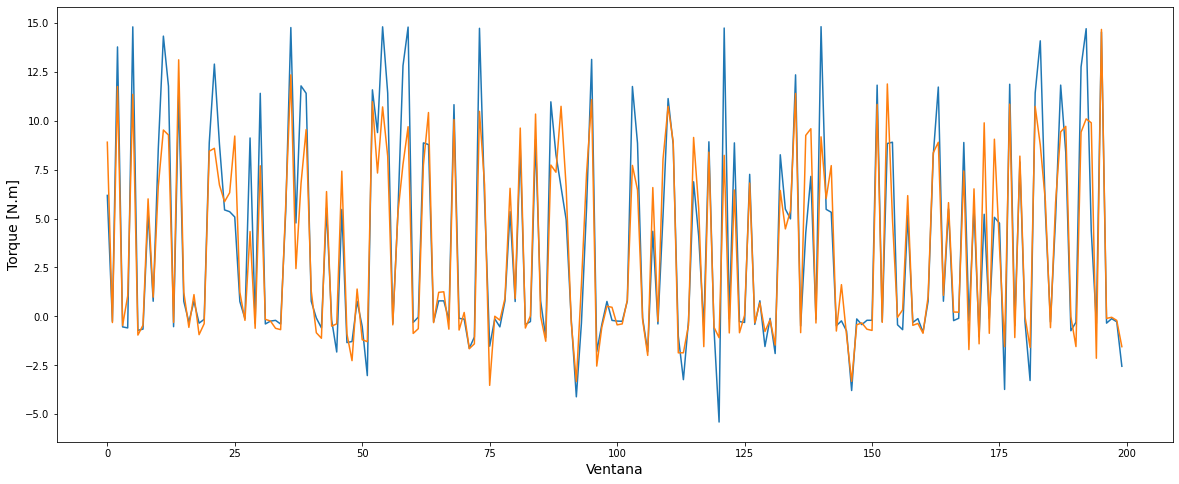

In [82]:
predicted = deep_mlp.predict(X_test_feat)
n = 200
plt.figure(figsize=(20,8))
plt.plot(Y_test_feat[0:n])
plt.plot(predicted[0:n])
plt.ylabel("Torque [N.m]", fontsize=14)
plt.xlabel("Ventana", fontsize=14)